In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()

In [5]:
# avarage per age or session
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [6]:
long_data = m_df.copy()

In [7]:
## MI for age in longtogeny

In [8]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_long = MIR(X,y)

In [9]:
long_indx = np.argsort(mi_score_long)[::-1][0:len(long_data.columns)] # syllble index
impsyl_long= list(long_data.columns[long_indx]) #syllable id
top_mi_score_long = mi_score_long[long_indx]
imp_long = np.array(['n']*len(mi_score_long))
imp_long[np.array(long_indx)]='y'

In [10]:
print('10 most informative syllables for age: ',impsyl_long)

10 most informative syllables for age:  [25, 63, 61, 5, 42, 67, 50, 70, 39, 32, 18, 98, 71, 59, 6, 24, 74, 13, 97, 2, 76, 33, 83, 90, 7, 79, 69, 11, 44, 16, 77, 49, 68, 4, 27, 54, 17, 0, 23, 62, 66, 64, 73, 30, 53, 93, 12, 9, 55, 36, 10, 60, 95, 41, 14, 85, 84, 52]


In [11]:
## MI for identity in longtogeny

In [12]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('mouse'))
mi_score_id = MIC(X,y)

In [13]:
id_indx = np.argsort(mi_score_id)[::-1][0:len(long_data.columns)] # syllble index
impsyl_id= list(long_data.columns[id_indx]) #syllable id
top_mi_score_id = mi_score_id[id_indx]
imp_id = np.array(['n']*len(mi_score_id))
imp_id[np.array(id_indx)]='y'

In [14]:
print('10 most informative syllables for identity: ',impsyl_id)

10 most informative syllables for identity:  [41, 83, 79, 60, 97, 84, 95, 85, 12, 53, 77, 69, 73, 76, 98, 10, 36, 68, 2, 71, 11, 64, 93, 6, 90, 4, 17, 62, 33, 44, 54, 0, 55, 14, 16, 5, 32, 30, 49, 18, 24, 23, 63, 27, 13, 66, 39, 74, 50, 9, 70, 67, 59, 42, 7, 52, 61, 25]


In [15]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v3.csv')
id_map = syllable_classes.set_index('Original ID')['Class']
class_sort = [id_map[k] for k in long_data.columns]

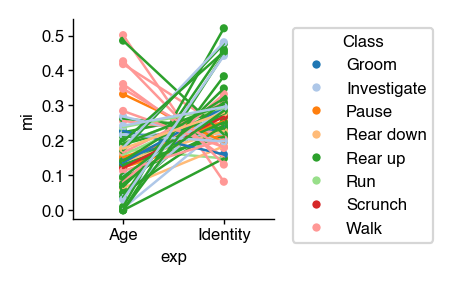

In [16]:
from sklearn.preprocessing import LabelEncoder
format_plots()
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_id,mi_score_long))
mi_df['syll'] = np.concatenate((np.array(long_data.columns),np.array(long_data.columns)))
mi_df['exp'] = ['Identity']*len(long_data.columns)+['Age']*len(long_data.columns)
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()
mi_df['class'] = np.concatenate((class_sort, class_sort))

le = LabelEncoder()
le.fit(np.unique(mi_df['class'].unique()))
y = le.transform(mi_df['class'])
palette = sns.color_palette("tab20", len(np.unique(mi_df['class'])))

# Plot
format_plots()
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)
for i in mi_df['syll'].unique():
    sns.pointplot(data=mi_df[mi_df.syll==i], x='exp', y='mi', join=True, 
                  color=palette[y[mi_df[mi_df['syll'] == i].index[0]]],
                  order=['Age', 'Identity'], markers=['o', 's'], scale=0.5, ax=ax)  # Adjust marker size with scale

# Create legend
legend_labels = le.inverse_transform(range(len(np.unique(mi_df['class']))))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=4) for label, color in zip(legend_labels, palette)]
plt.legend(handles=legend_handles, title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside of the panel
sns.despine()
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'MI_aging_vs_indv_longv2_classes.pdf')

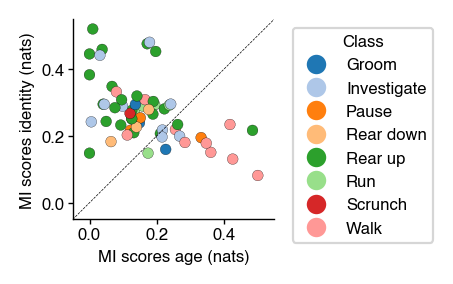

In [17]:
# Label encoding for classes
le = LabelEncoder()
le.fit(np.unique(mi_df['class'].unique()))
mi_df['class_encoded'] = le.transform(mi_df['class'])

# Separate the data into male and female MI scores
Identity_mi = mi_df[mi_df['exp'] == 'Identity']
Age_mi = mi_df[mi_df['exp'] == 'Age']

# Ensure that the syllables are aligned between male and female dataframes
Identity_mi = Identity_mi.set_index('syll')
Age_mi = Age_mi.set_index('syll')

# Merge male and female MI scores based on syllables
merged_mi_df = Identity_mi[['mi', 'class_encoded']].join(Age_mi[['mi']], lsuffix='_identity', rsuffix='_age')

# Plot
palette = sns.color_palette("tab20", len(np.unique(mi_df['class'])))
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)
sns.scatterplot(data=merged_mi_df, x='mi_age', y='mi_identity', hue='class_encoded', palette=palette, s=15,
               edgecolor='black', linewidth=0.1)

# Add labels and title
plt.xlim([-0.05, 0.55])
plt.ylim([-0.05, 0.55])
plt.xlabel('MI scores age (nats)')
plt.ylabel('MI scores identity (nats)')

# Create legend
legend_labels = le.inverse_transform(range(len(np.unique(mi_df['class']))))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, palette)]
plt.legend(handles=legend_handles, title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add identity line
plt.plot([-0.05, 0.55], [-0.05, 0.55], 'k--', lw=0.25)

sns.despine()
plt.show()

In [18]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'MI_aging_vs_indv_longv2_classes_scatter.pdf')

In [19]:
## plot example for 3 syllables with highest age MI across life for 4 mice
n=10
df_age = long_data[impsyl_long[0:n]]

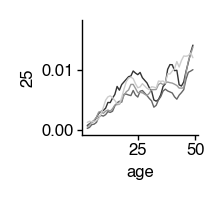

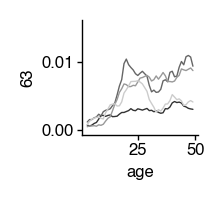

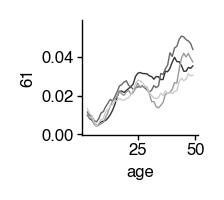

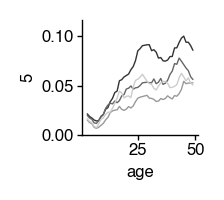

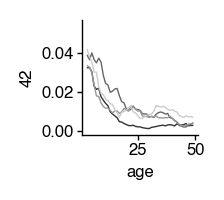

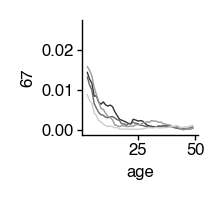

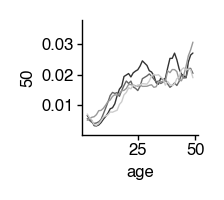

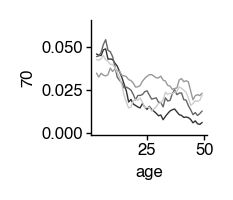

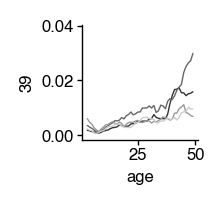

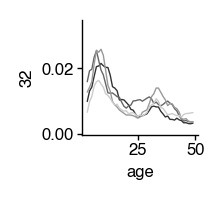

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
n=10

rolling_window_size = 5  # You can adjust this value according to your preference

for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75, 0.75) 
    sns.lineplot(data=df_age, x='age', y=impsyl_long[i], hue='mouse', marker='none',
                 palette='gray',
                 hue_order=['M4_02', 'M3_02', 'M2_02', 'M1_02'],
                 legend=False, linewidth=0.5, ax=ax)

    # Apply rolling average
    for line in ax.lines:
        y = line.get_ydata()
        rolling_y = pd.Series(y).rolling(window=rolling_window_size, min_periods=1, center=True).mean().values
        line.set_ydata(rolling_y)

    sns.despine()
    fig.savefig(c.dana_save_path / "fig3" / ('example_MI_aging_longv2_'+str(impsyl_long[i])+'.pdf'))


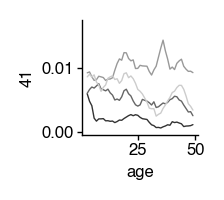

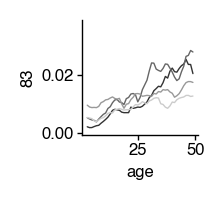

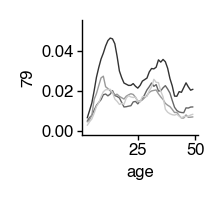

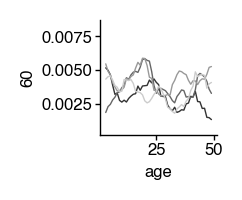

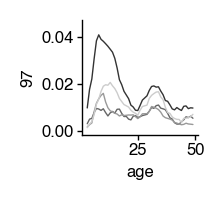

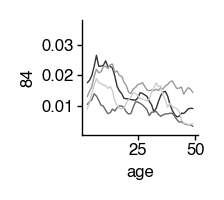

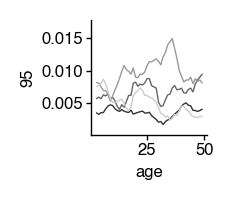

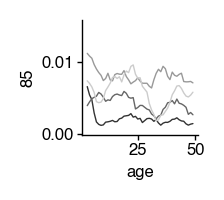

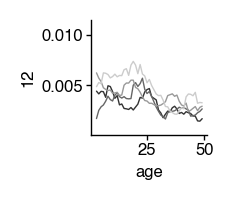

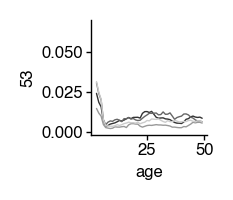

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
n=10
df_age = long_data[impsyl_id[0:n]]
rolling_window_size = 5  # You can adjust this value according to your preference

for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75, 0.75) 
    sns.lineplot(data=df_age, x='age', y=impsyl_id[i], hue='mouse', marker='none',
                 palette='gray',
                 hue_order=['M4_02', 'M3_02', 'M2_02', 'M1_02'],
                 legend=False, linewidth=0.5, ax=ax)

    # Apply rolling average
    for line in ax.lines:
        y = line.get_ydata()
        rolling_y = pd.Series(y).rolling(window=rolling_window_size, min_periods=1, center=True).mean().values
        line.set_ydata(rolling_y)

    sns.despine()
    fig.savefig(c.dana_save_path / "fig3" / ('example_MI_id_longv2_'+str(impsyl_long[i])+'.pdf'))